In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import sys
import logging

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdChemReactions

import pandas as pd
import numpy as np

import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar

dask.config.set({"dataframe.convert-string": False})
ProgressBar().register()

from linux_qm.src.render import indigo, draw_reacting_mapnums
from linux_qm.src.util import load_smiles3D
from linux_qm.qm.orca.orca import OrcaDriver

In [33]:
df = pd.read_csv('../data/slv_amides/amide_training_set.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15999 entries, 0 to 15998
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rxn_id            15999 non-null  int64  
 1   acid_smi          15999 non-null  object 
 2   amine_smi         15999 non-null  object 
 3   product_smi       15999 non-null  object 
 4   activators_names  9719 non-null   object 
 5   yield             15999 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 750.1+ KB


In [34]:
df['rxn_smi'] = df.amine_smi + '.' + df.acid_smi + '>>' + df.product_smi
df.rxn_smi

0        N[C@@H](CCCCNC(=O)C(F)(F)F)C(=O)O.OC(CCCCCCCCC...
1        NCC(=O)NCC(=O)NCC(=O)O.OC(CSC(C)=O)=O>>[CH3:1]...
2        NCCN.OC(=O)CCN(CCNC(=O)CCN(CCOCCOCCOCC1OCCO1)C...
3        NCCN.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH:3]([O:19]...
4        NCc1cccc(CN)c1.OC(CC(OC)OC)=O>>[CH3:1][O:2][CH...
                               ...                        
15994    CCO[Si](CCCN)(OCC)OCC.OC(=O)CC=O>>[CH3:1][CH2:...
15995    NCCC(=O)O.OC(C(=C)C)=O>>[CH2:1]=[C:2]([C:4]([N...
15996    N1CCOCC1.OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]...
15997    CC[C@H](C)N.OC(=O)c1cc(Cl)cc(F)[n]1>>[CH3:1][C...
15998    NCc1ccccc1.OC(=O)c1[n]cc[n][n]1>>[O:1]=[C:2]([...
Name: rxn_smi, Length: 15999, dtype: object

# Filter by Heavy atom count

<Axes: xlabel='ha_count', ylabel='Count'>

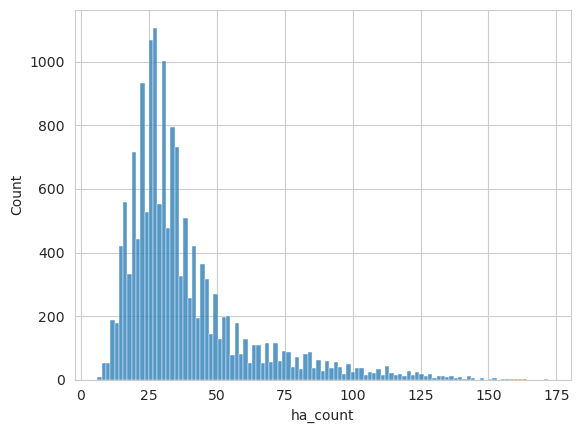

In [35]:
import seaborn as sns

def ha_count(smi: str):
    mol = Chem.MolFromSmiles(smi)
    return mol.GetNumHeavyAtoms() if mol else None


ha = df.rxn_smi.str.split('>>').apply(lambda x: x[1]).apply(ha_count)
ha.name = 'ha_count'


sns.histplot(ha)

In [36]:
df = df[ha < 40].copy()

# Reactom atom-to-atom mapping

[NH2:1][c:2]1[cH:8]cc(O)[cH:4][cH:3]1.[CH3:9][C:10](=O)[OH:11]>>CC(=O)[NH:1][c:2]1[cH:3][cH:4][c:10]([OH:11])[cH:9][cH:8]1
Reacting Atom Idx: ((0, 2, 3, 4, 5, 6), (0, 1, 2))
Mapped reacting atom: N 1
Mapped reacting atom: C 8
Mapped reacting atom: C 0
Mapped reacting atom: C 0
Mapped reacting atom: O 0
Mapped reacting atom: C 4
Mapped reacting atom: C 9
Mapped reacting atom: C 10
Mapped reacting atom: O 0


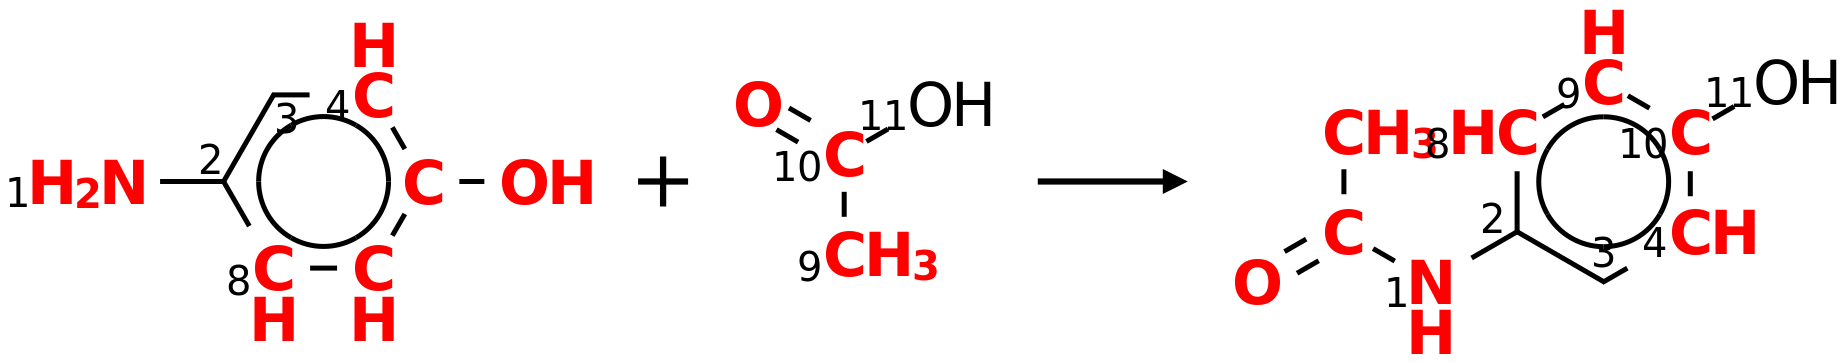

[1, 8, 0, 0, 0, 4, 9, 10, 0]

In [37]:
# rxn_smi = df.rxn_smi.sample(1).iat[0]
rxn_smi = "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc2ccc(O)cc2)=O"

ind_rxn = indigo.loadReaction(rxn_smi)
ind_rxn.automap("discard")
rxn_smi = ind_rxn.smiles()

print(rxn_smi)

draw_reacting_mapnums(rxn_smi)

In [38]:
import re

re.sub(r':\d+','',  rxn_smi)

'[NH2][c]1[cH]cc(O)[cH][cH]1.[CH3][C](=O)[OH]>>CC(=O)[NH][c]1[cH][cH][c]([OH])[cH][cH]1'

In [39]:
from rxnmapper import BatchedMapper, RXNMapper
rxn_mapper = BatchedMapper(batch_size=8)

def ind_rxn_map(rxn_smi):
    try:
        ind_rxn = indigo.loadReaction(rxn_smi)
        ind_rxn.automap("discard")
        return ind_rxn.smiles()
    except:
        return None

def rxn_map(rxn_smi):
    clear_smi = re.sub(r':\d+','',  rxn_smi)
    mapped_rxn = list(rxn_mapper.map_reactions([clear_smi]))[0]
    return mapped_rxn

In [40]:
# rxn_arr = df.rxn_smi.sample(100)
#
# %timeit list(rxn_mapper.map_reactions(rxn_arr))
# %timeit rxn_arr.apply(ind_rxn_map)
# rxn_mapper.get_attention_guided_atom_maps_for_reactions([rxn_smi])

In [41]:
df.rxn_smi = df.rxn_smi.str.replace(r':\d+','', regex=True)

In [42]:
dds = dd.from_pandas(df.rxn_smi, npartitions=128)

df.rxn_smi = dds.apply(ind_rxn_map, meta=dds). compute(scheduler='threads')

# df.rxn_smi = df.rxn_smi.apply(ind_rxn_map)

[########################################] | 100% Completed | 12.45 s
[########################################] | 100% Completed | 12.56 s


In [43]:
df.dropna(subset=['rxn_smi'], inplace=True)
df

,rxn_id,acid_smi,amine_smi,product_smi,activators_names,yield,rxn_smi
1,230946,OC(CSC(C)=O)=O,NCC(=O)NCC(=O)NCC(=O)O,[CH3:1][C:2]([S:4][CH2:5][C:6]([NH:8][CH2:9][C...,N-Hydroxysuccinimide,40.0,[NH2:1][CH2:2][C:3]([NH:5][CH2:6][C:7]([NH:9][...
3,371496,OC(CC(OC)OC)=O,NCCN,[CH3:1][O:2][CH:3]([O:19][CH3:20])[CH2:4][C:5]...,NaN,65.0,[NH2:1][CH2:2][CH2:3][NH2:4].[OH:5][C:6](=[O:1...
4,371499,OC(CC(OC)OC)=O,NCc1cccc(CN)c1,[CH3:1][O:2][CH:3]([O:25][CH3:26])[CH2:4][C:5]...,NaN,63.0,[NH2:1][CH2:2][c:3]1[cH:10][c:7]([CH2:8][NH2:9...
5,375178,OC(=O)[C@@H]1C[C@H]1c1cc[n]cc1,CNC,[CH3:1][N:2]([C:4]([C@H:6]1[C@H:8]([c:9]2[cH:1...,NaN,32.0,[CH3:1][NH:2][CH3:3].O[C:5]([C@H:7]1[C@H:9]([c...
8,380793,C(=O)CC(O)=O,NCCNCc1ccccc1,[O:1]=[C:2]([NH:17][CH2:18][CH2:19][NH:20][CH2...,NaN,69.0,[NH2:1][CH2:2][CH2:3][NH:4][CH2:5][c:6]1[cH:11...
...,...,...,...,...,...,...,...
15994,34657822,OC(=O)CC=O,CCO[Si](CCCN)(OCC)OCC,[CH3:1][CH2:2][O:3][Si:4]([O:31][CH2:32][CH3:3...,NaN,89.0,[CH3:1][CH2:2][O:3][Si:4]([O:12][CH2:13][CH3:1...
15995,34683894,OC(C(=C)C)=O,NCCC(=O)O,[CH2:1]=[C:2]([C:4]([NH:6][CH2:7][CH2:8][C:9](...,Anhydrides,57.0,[NH2:1][CH2:2][CH2:3][C:4]([OH:6])=[O:5].O[C:8...
15996,34697857,OC(c1cc(NC(CC(C)(C)C)(C)C)[n]c(Cl)[n]1)=O,N1CCOCC1,[CH3:1][C:2]([CH2:5][C:6]([NH:9][c:10]1[n:24][...,TBD,82.0,[NH:1]1[CH2:6][CH2:5][O:4][CH2:3][CH2:2]1.O[C:...
15997,34705858,OC(=O)c1cc(Cl)cc(F)[n]1,CC[C@H](C)N,[CH3:1][CH2:2][C@@H:3]([NH:5][C:6]([c:8]1[n:15...,NaN,91.0,[CH3:1][CH2:2][C@@H:3]([NH2:5])[CH3:4].O[C:7](...


[NH2:1][CH:2]1[CH2:7][CH2:6][CH2:5][CH2:4][CH2:3]1.O[C:9]([c:11]1[n:22][n:21][n:13]([CH2:14][c:15]2[cH:20][cH:19][cH:18][cH:17][cH:16]2)[cH:12]1)=[O:10]>>[O:10]=[C:9]([NH:1][CH:2]1[CH2:7][CH2:6][CH2:5][CH2:4][CH2:3]1)[c:11]1[cH:12][n:13]([CH2:14][c:15]2[cH:16][cH:17][cH:18][cH:19][cH:20]2)[n:21][n:22]1
((0,), (0, 1))
Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 9


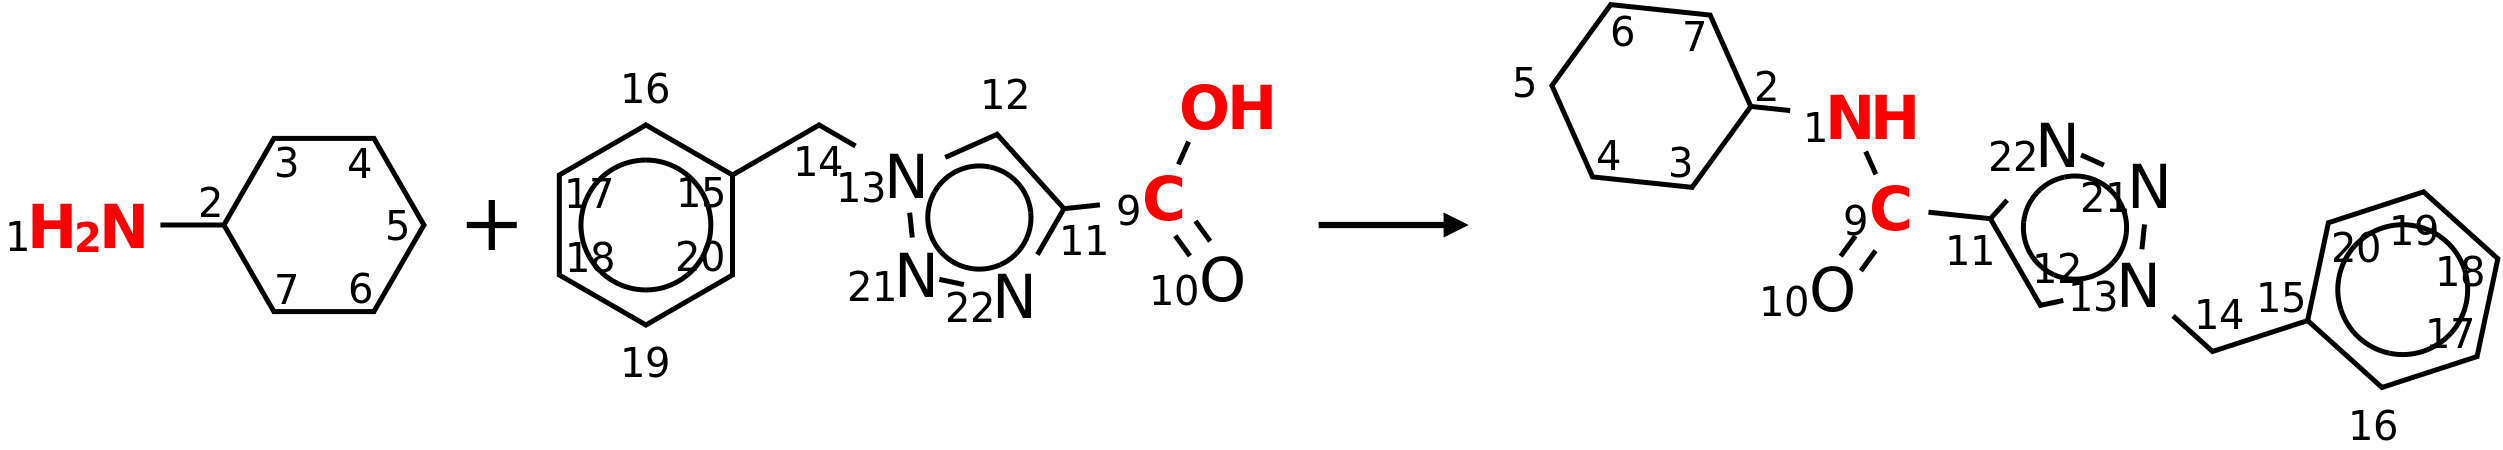

[1, 0, 9]

In [44]:
rxn_smi = df.rxn_smi.sample(1).iat[0]
print(rxn_smi)

rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
rxn.Initialize()
print(rxn.GetReactingAtoms())
draw_reacting_mapnums(rxn_smi)

# Filter by amine and acid mapping


In [58]:
def check_amide_mapping(rxn_smi):
    try:
        rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
        rxn.Initialize()
        mapped_atoms = rxn.GetReactingAtoms()
    except:
        return False

    if len(mapped_atoms) != 2:
        return False
    if len(mapped_atoms[0]) != 1:
        return False
    if len(mapped_atoms[1]) != 2:
        return False

    if len(rxn.GetProducts()) > 1:
        return False

    if len(rxn.GetReactants()) != 2:
        return False

    amine, acid = rxn.GetReactants()

    # check for amine reacting atom
    amine_atom = amine.GetAtomWithIdx(mapped_atoms[0][0])
    if amine_atom.GetSymbol() != 'N':
        return False

    # check for neighbors of N in amine
    for nei in amine_atom.GetNeighbors():
        if nei.GetSymbol() not in ['H', 'C']:
            return False


    # check acid
    acid_ids = mapped_atoms[1]
    carbon_id = [i for i in acid_ids if acid.GetAtomWithIdx(i).GetSymbol() == 'C']
    oxygen_id = [i for i in acid_ids if acid.GetAtomWithIdx(i).GetSymbol() == 'O']
    others = [i for i in acid_ids if acid.GetAtomWithIdx(i).GetSymbol() not in ['C', 'O']]

    if others:
        return False
    if len(carbon_id) != 1:
        return False
    if len(oxygen_id) != 1:
        return False

    # other than acids
    carbon = acid.GetAtomWithIdx(carbon_id[0])
    for nei in carbon.GetNeighbors():
        if nei.GetSymbol() not in ['O', 'C']:
            return False

    return True


def map_amide_coupling(rxn_smi):
    # try indigo first
    mapped_smi = ind_rxn_map(rxn_smi)
    print(mapped_smi)
    rxn = rdChemReactions.ReactionFromSmarts(mapped_smi)
    rxn.Initialize()
    mapped_atoms = rxn.GetReactingAtoms()
    print(mapped_atoms)
    if check_amide_mapping(mapped_atoms, rxn):
        return mapped_smi

    # rxn_mapped
    mapped_smi = rxn_map(rxn_smi)
    rxn = rdChemReactions.ReactionFromSmarts(mapped_smi)
    mapped_atoms = rxn.GetReactingAtoms()
    if check_amide_mapping(mapped_atoms, rxn):
        return mapped_smi
    return None

True
Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 13


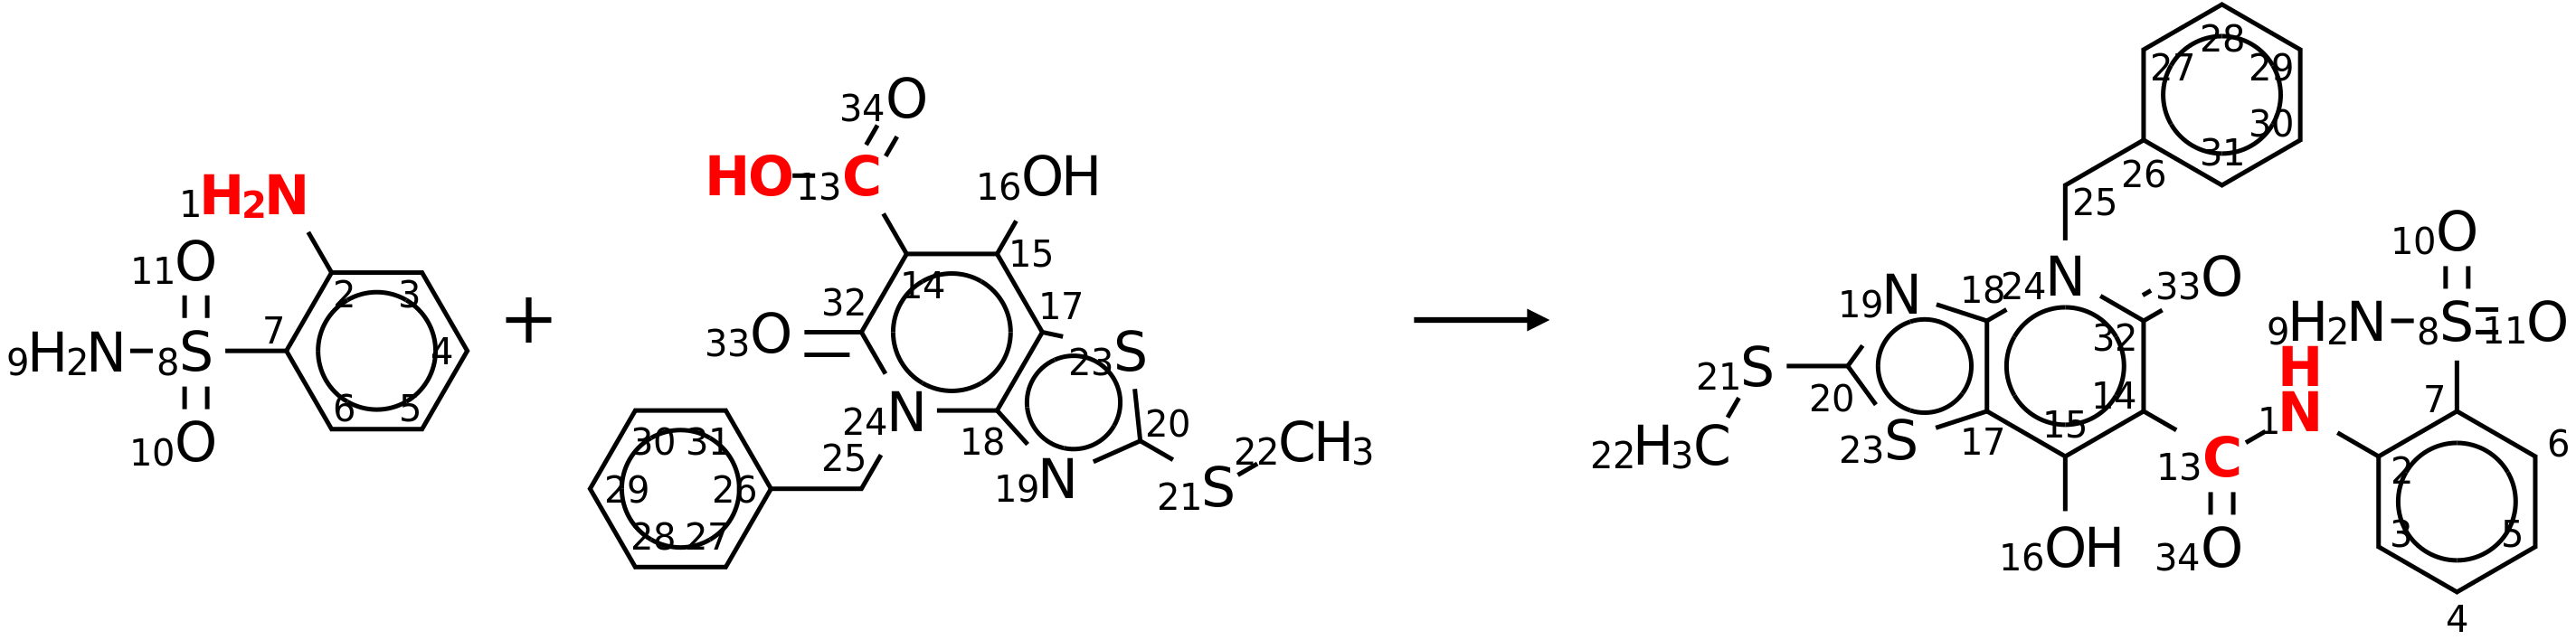

[1, 0, 13]

In [90]:
rxn_smi = df.rxn_smi.sample(1).iat[0]
print(check_amide_mapping(rxn_smi))
draw_reacting_mapnums(rxn_smi)

In [47]:
# %timeit df.rxn_smi.sample(100).apply(check_amide_mapping)

In [91]:
rxn_ok = df.rxn_smi.apply(check_amide_mapping)

In [103]:
(~rxn_ok).sum()

200

Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 6


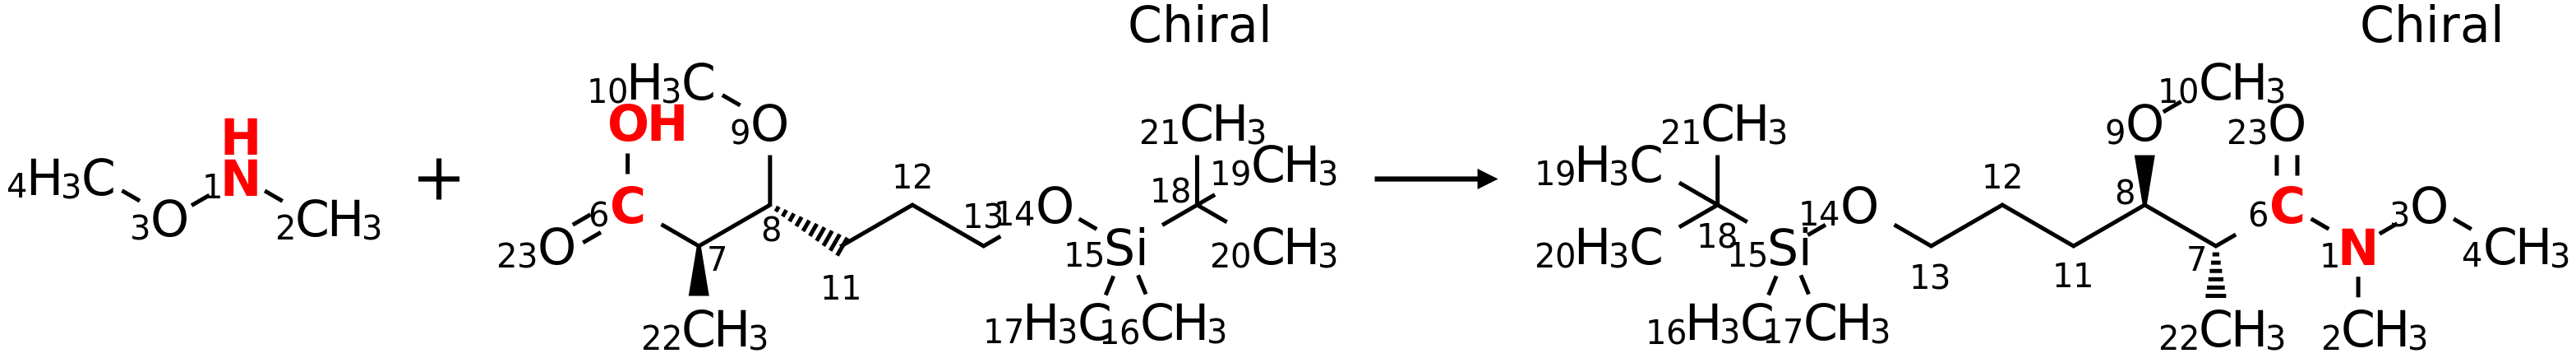

[1, 0, 6]

In [102]:
draw_reacting_mapnums(df[~rxn_ok].rxn_smi.sample(1).iat[0])

In [104]:
df = df[rxn_ok].copy()
df.shape

(9491, 7)

In [105]:
df.to_csv('../data/slv_amides/amide_mapped_training_set.csv', index=False)

# ORCA amine calculation

In [106]:
def get_amine_atoms(mol, reacting_nitrogen_idx: int):
    amine_aids = [reacting_nitrogen_idx]
    atom = mol.GetAtomWithIdx(reacting_nitrogen_idx)
    for a in atom.GetNeighbors():
        if a.GetSymbol() == 'C':
            amine_aids.append(a.GetIdx())
    return amine_aids

def orca_calculation(conf):
    orca = OrcaDriver()

    orca.options['n_jobs'] = 1

    orca.options['method'] = 'XTB2'
    orca.geometry_optimization(conf)

    orca.options['method'] = 'HF-3c'
    # orca.options['method'] = 'BP86 def2-SVP def2/J D3BJ RIJCOSX'
    data = orca.single_point(conf, calc_npa=False)

    # data = orca.geometry_optimization(conf, calc_npa=True)
    return data

def gen_amine_electronic(rxn_smi):
    # try rxn_mapper:
    rxn_smi = rxn_map(rxn_smi)

    # load rxn
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get reactants
    amine, acid = rxn.GetReactants()
    amine_raids = get_amine_atoms(amine, rxn.GetReactingAtoms()[0][0])


    mol = load_smiles3D(Chem.MolToSmiles(amine), opt=True)

    # qm calculation
    data = orca_calculation(mol.GetConformer())

    for i in amine_raids:
        logging.debug(amine.GetAtomWithIdx(i).GetSymbol())


    mull_charges = data.atomcharges['mulliken'][amine_raids]
    low_charges = data.atomcharges['lowdin'][amine_raids]
    # npa_charges = data.atomcharges['npa'][amine_raids]

    homo = data.moenergies[0][data.homos[0]]
    lumo = data.moenergies[0][data.homos[0] + 1]

    logging.debug(f"Mulliken charges: {mull_charges}")
    logging.debug(f"Lowdig charges: {low_charges}")
    logging.debug(f"HOMO LUMO: {homo} {lumo}")

    descriptor = np.hstack([mull_charges, low_charges, homo, lumo])

    return descriptor

In [107]:
mol = load_smiles3D("NCF", opt=True)

# qm calculation
data = orca_calculation(mol.GetConformer())
data.atomcharges

{'mulliken': array([-0.509511,  0.116581, -0.324349,  0.220682,  0.224348,  0.126117,
         0.146132]),
 'lowdin': array([-0.343624,  0.140078, -0.257317,  0.153676,  0.155419,  0.066584,
         0.085185])}

In [108]:
gen_amine_electronic("Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O")

array([-0.497356  ,  0.114101  , -0.306927  ,  0.103188  , -8.11930586,
        4.78533975])

In [114]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

reactions = [
    # "Nc1ccc(C)cc1.CC(O)=O>>CC(Nc1ccc(C)cc1)=O",
    # "Nc1ccc(O)cc1.CC(O)=O>>CC(Nc1ccc(O)cc1)=O",
    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    # "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",

    # "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",
    # "Nc1ccc(NC)cc1.CC(O)=O>>CC(Nc1ccc(NC)cc1)=O",
    # "Nc1ccc(N(C)C)cc1.CC(O)=O>>CC(Nc1ccc(N(C)C)cc1)=O",

    "Nc1ccc(N(=O)=O)cc1.CC(O)=O>>CC(Nc1ccc(N(=O)=O)cc1)=O",
    "Nc1ccc(N=O)cc1.CC(O)=O>>CC(Nc1ccc(N=O)cc1)=O",
    "Nc1ccc(NO)cc1.CC(O)=O>>CC(Nc1ccc(NO)cc1)=O",
    "Nc1ccc(NN)cc1.CC(O)=O>>CC(Nc1ccc(NN)cc1)=O",
    "Nc1ccc(N)cc1.CC(O)=O>>CC(Nc1ccc(N)cc1)=O",


    # "Nc1ccc(F)cc1.CC(O)=O>>CC(Nc1ccc(F)cc1)=O",
    # "Nc1ccc(Cl)cc1.CC(O)=O>>CC(Nc1ccc(Cl)cc1)=O",
    # "Nc1ccc(Br)cc1.CC(O)=O>>CC(Nc1ccc(Br)cc1)=O",
    # "Nc1ccc(I)cc1.CC(O)=O>>CC(Nc1ccc(I)cc1)=O",
]

# labels = ['C', 'N', 'O', 'F']
# labels = ['NH2', 'NHMe', 'NMe2']
# labels = ['F', 'Cl', 'Br', 'I']
labels = ['NO2','NO', 'NH2OH', 'NHNH2', 'NH2']

amine_descr = np.empty((0, 6))
for rxn_smi in reactions:
    d = gen_amine_electronic(rxn_smi)
    amine_descr = np.vstack([amine_descr, d])

res = pd.DataFrame(amine_descr,
                   # columns=['mul_N', 'mul_C', 'low_N', 'low_C', 'npa_N', 'npa_C'],
                   columns=['mul_N', 'mul_C', 'low_N', 'low_C', 'HOMO', 'LUMO'],
                   index=labels)
res

INFO:root:Method: XTB2
DEBUG:root:ORCA INPUT:
!XTB2 OPT  
%geom MaxIter 100 end
%maxcore 2000
*xyz 0 1
N           -2.75849066         -0.57229171         -0.24266491
C           -1.41351828         -0.22636796         -0.08550278
C           -0.74088287          0.45811684         -1.10327019
C            0.63311727          0.70391681         -1.01632927
C            1.34924282          0.22089594          0.08441565
N            2.79216472          0.47106885          0.18278619
O            3.39000428          0.02017702          1.17053441
O            3.32835448          1.12149726         -0.72595467
C            0.70136007         -0.51502880          1.08263714
C           -0.67318058         -0.75116804          0.97906072
H           -3.24083630         -0.78303579          0.62575831
H           -3.28821425          0.06324015         -0.83149683
H           -1.28498700          0.80721929         -1.97794759
H            1.12405001          1.25527562         -1.81523981
H

,mul_N,mul_C,low_N,low_C,HOMO,LUMO
NO2,-0.497085,0.144528,-0.295287,0.137258,-8.844353,2.542523
NO,-0.497950,0.145700,-0.295130,0.138893,-8.322602,2.746146
NH2OH,-0.498675,0.092137,-0.313660,0.076483,-7.206690,5.219416
NHNH2,-0.498984,0.084760,-0.315968,0.068162,-6.855963,5.514197
NH2,-0.498682,0.083398,-0.315909,0.066168,-6.944536,5.388643


In [115]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

res.iloc[:] = scaler.fit_transform(res)
res

,mul_N,mul_C,low_N,low_C,HOMO,LUMO
NO2,1.736065,1.197681,1.212328,1.193532,-1.511334,-1.296211
NO,0.474347,1.238458,1.228317,1.242482,-0.859392,-1.144493
NH2OH,-0.583161,-0.625140,-0.658848,-0.626022,0.534971,0.698325
NHNH2,-1.033879,-0.881806,-0.893903,-0.875146,0.973215,0.917964
NH2,-0.593372,-0.929193,-0.887894,-0.934845,0.862540,0.824415


<Axes: >

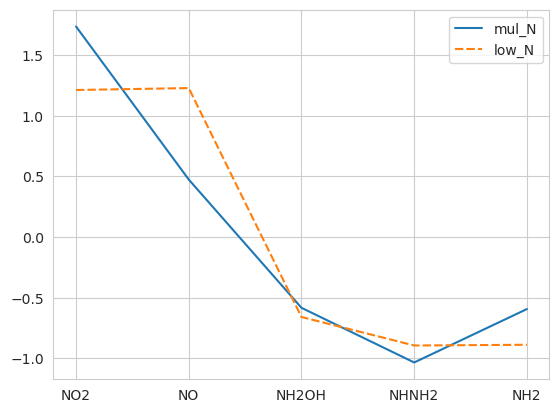

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    # res[['mul_N', 'low_N', 'npa_N']]
    res[['mul_N', 'low_N']]
)

<Axes: >

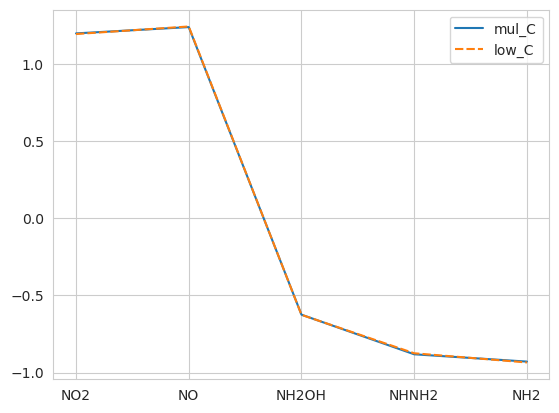

In [117]:
sns.lineplot(
    # res[['mul_C', 'low_C', 'npa_C']]
    res[['mul_C', 'low_C']]
)

<Axes: >

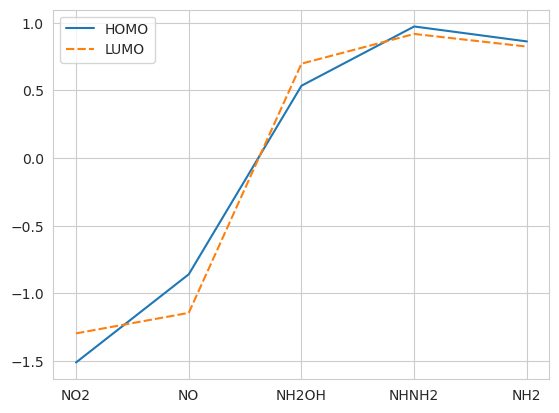

In [118]:
sns.lineplot(
    # res[['mul_C', 'low_C', 'npa_C']]
    res[['HOMO', 'LUMO']]
)

In [156]:
from linux_qm.desc.electronic import gen_amine_electronic

gen_amine_electronic("Nc1ccc(N(=O)=O)cc1.CC(O)=O>>CC(Nc1ccc(N(=O)=O)cc1)=O")

array([-0.497085,  0.144528, -0.295287,  0.137258, -8.844353,  2.542523])

In [120]:
import logging
logging.getLogger().setLevel(logging.WARNING)

df.rxn_smi.sample(1).apply(gen_amine_electronic)

5343    [-0.500474, -0.271553, -0.33647, -0.162904, -9...
Name: rxn_smi, dtype: object

In [153]:
def check_amine_atoms(rxn_smi):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get reactants
    amine, acid = rxn.GetReactants()
    Chem.SanitizeMol(acid)
    Chem.SanitizeMol(amine)
    return get_amine_atoms(amine, rxn.GetReactingAtoms()[0][0])

amine_atoms = df.rxn_smi.apply(check_amine_atoms)
amine_atoms.apply(len).value_counts(dropna=False)

rxn_smi
2    7948
3    1543
Name: count, dtype: int64

# Acid electronic descriptor

In [130]:
def get_acid_atoms(mol, react_acid_ids: list):
    # Order should be
    # [C, =O, -OH, C bounded to C=O]
    result = []
    for i in react_acid_ids:
        if mol.GetAtomWithIdx(i).GetSymbol() == 'C':
            result.append(i)
    for i in react_acid_ids:
        atom = mol.GetAtomWithIdx(i)
        if atom.GetSymbol() == 'O' and atom.GetTotalNumHs() == 1:
            result.append(i)
    for i in react_acid_ids:
        atom = mol.GetAtomWithIdx(i)
        if atom.GetSymbol() == 'O' and atom.GetTotalNumHs() == 0:
            result.append(i)

    atom = mol.GetAtomWithIdx(result[0])
    for nei in atom.GetNeighbors():
        if nei.GetSymbol() == 'C':
            result.append(nei.GetIdx())

    return result



In [154]:
def get_acid_electronic(rxn_smi):
    # try:
    # try rxn_mapper:
    rxn_smi = rxn_map(rxn_smi)

    # load rxn
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get reactants
    amine, acid = rxn.GetReactants()
    Chem.SanitizeMol(acid)
    Chem.SanitizeMol(amine)

    acid_atoms = get_acid_atoms(acid, rxn.GetReactingAtoms()[1])
    logging.debug(f'Acid atom ids: {acid_atoms}')

    logging.info(f"Heavy Atom Count: {acid.GetNumHeavyAtoms()}")

    mol = load_smiles3D(Chem.MolToSmiles(acid), opt=True)

    # qm calculation
    data = orca_calculation(mol.GetConformer())

    charges = np.hstack([
        data.atomcharges['mulliken'][acid_atoms],
        data.atomcharges['lowdin'][acid_atoms],
        # data.atomcharges['npa'][amine_raids],
    ])
    homo = data.moenergies[0][data.homos[0]]
    lumo = data.moenergies[0][data.homos[0] + 1]

    return np.hstack([charges, homo, lumo]).round(6)

    # except Exception as e:
    #     logging.warning(f"{type(e).__name__}: {e} for rxn_smi: {rxn_smi}")
    #     return None

In [146]:
def check_acid_atoms(rxn_smi):
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smi, useSmiles=True)
    rxn.Initialize()

    # get reactants
    amine, acid = rxn.GetReactants()
    Chem.SanitizeMol(acid)
    Chem.SanitizeMol(amine)
    return get_acid_atoms(acid, rxn.GetReactingAtoms()[1])

# rxn_smi = df.rxn_smi.sample(1).iat[0]
# ge

acid_atoms = df.rxn_smi.apply(check_acid_atoms)

In [155]:
acid_atoms.apply(len).value_counts(dropna=False)

rxn_smi
3    9491
Name: count, dtype: int64

Reacting Atom Idx: ((0,), (0, 1))
Mapped reacting atom: N 1
Mapped reacting atom: O 0
Mapped reacting atom: C 12


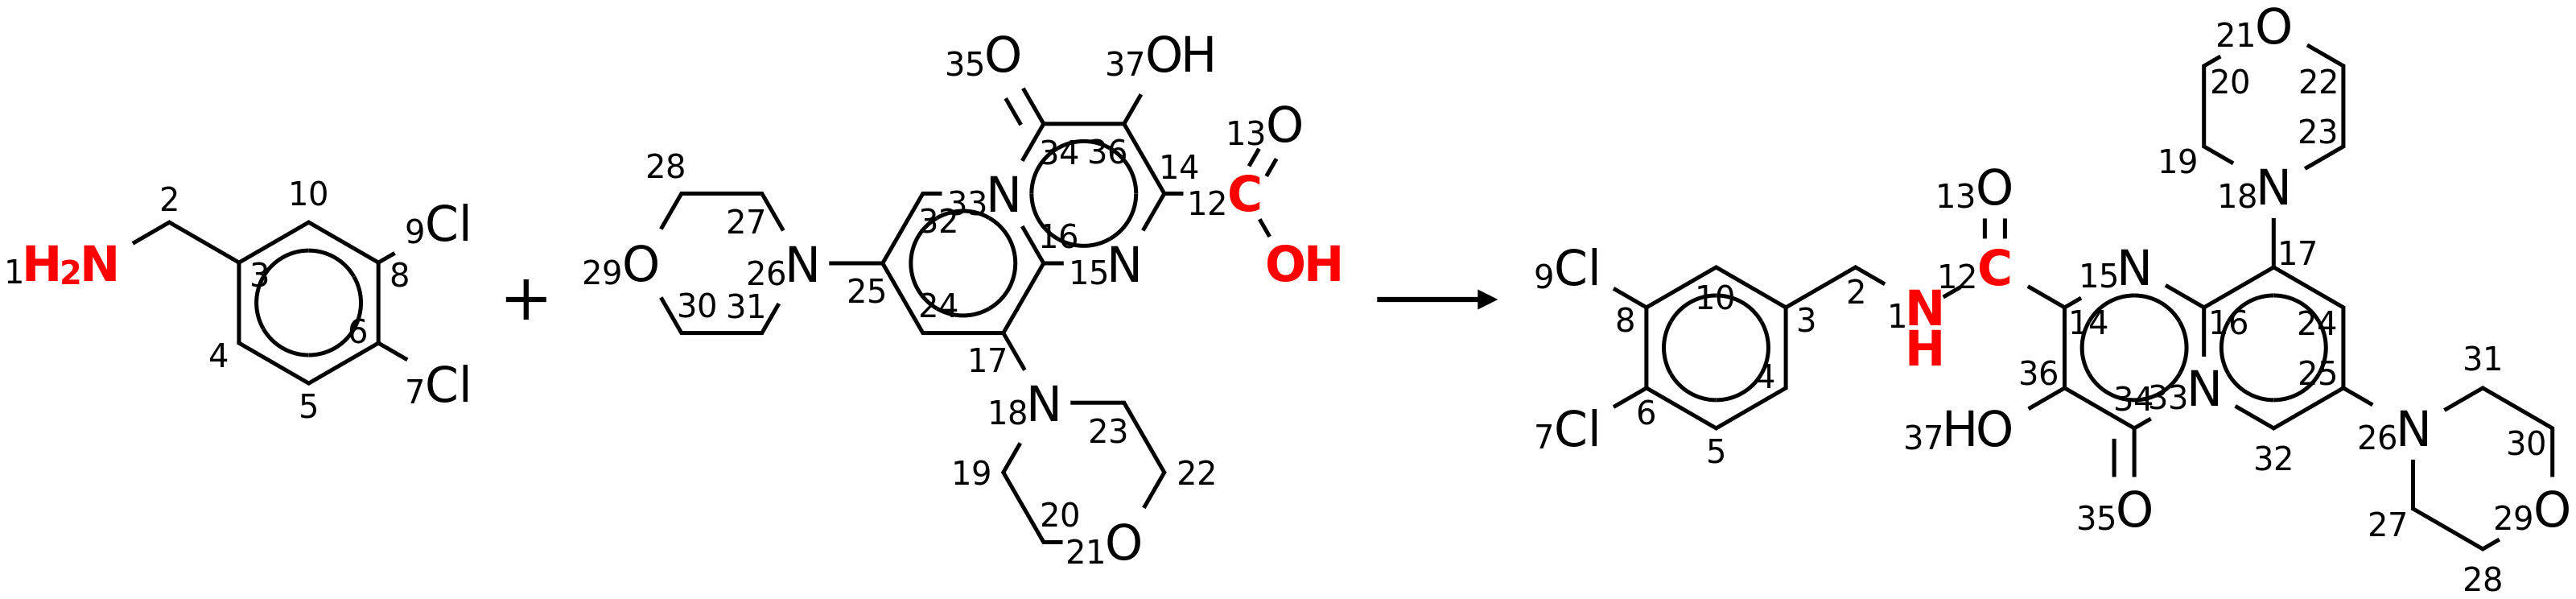

array([ 0.497168, -0.407157, -0.464876, -0.482543,  0.367042, -0.330851,
       -0.311045, -0.328934, -6.755934,  2.246844])

In [134]:
rxn_smi = df.rxn_smi.sample(1).iat[0]

draw_reacting_mapnums(rxn_smi)

get_acid_electronic(rxn_smi)

# Dask parallel run

In [121]:
dds = dd.from_pandas(df.rxn_smi[:512], npartitions=16)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 540.32 s
[########################################] | 100% Completed | 540.42 s


In [54]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=8)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 181.21 s
[########################################] | 100% Completed | 181.20 s


In [34]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=16)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

[########################################] | 100% Completed | 117.24 s


In [ ]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=8)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

In [ ]:
dds = dd.from_pandas(df.rxn_smi[:128], npartitions=4)
amine_descr = dds.apply(gen_amine_electronic,
                          # args=(query,),
                          meta=dds).compute(scheduler='processes')

In [ ]:
%%time
df[:128].rxn_smi.apply(gen_amine_electronic)

In [ ]:
for i, row in df[:16].iterrows():
    amine_descr = gen_amine_electronic(row['rxn_smi'])
    print(amine_descr)

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)
gen_amine_electronic(df.rxn_smi.iat[2])

In [ ]:
draw_reacting_mapnums(df.rxn_smi.iat[2])